In [1]:
#Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import pysindy as ps

In [2]:
random.seed(29)

Time-steps check

Validation check

Results check

## Short:
Train 15-01-1951 - 11-01-1952 (362)

Val 12-01-1952 - 10-07-1952 (181)

Test 11-07-1952 - 08-01-1953 (182)

## Long:
Train 15-01-1951 - 10-01-1981 (10954)

Val 11-01-1981 - 09-01-1996 (5477)

Test 10-01-1996 - 06-01-2011 (5476)

In [3]:
weather_df_norm = pd.read_csv('dataset/dutch_weather_norm_denoised.csv', parse_dates = ['DATE'])

In [4]:
## KNOBS ##
n_future = 1 # How many steps in the future do I want to predict
n_past = 7 # How many past steps do I want to use to predict n_future
feature_columns = ['CLOUDINESS', 'HUMIDITY', 'MAX_TEMP', 'MIN_TEMP', 'MEAN_TEMP', 'PRECIPITATION']

In [5]:
def multivariate_supervised_learning(length, n_future = 1, n_past = 7):
    """
    Input:
    length = length for evaluation
    n_future = future time-steps to be predicted
    n_past = past timesteps to be predicted
    
    Output:
    Train test splits for control variables (X) and target variable (u) as dataframes
    """
    
    if length == 'short':
        length = weather_df_norm[0:732][feature_columns]
    elif length == 'medium':
        length = weather_df_norm[0:7304][feature_columns]
    elif length == 'long':
        length = weather_df_norm[0:21914][feature_columns]
    else:
        print('No proper length accepted')
        return 0
        
    X = []
    y = []
    
    for i in range(n_past, len(length) - n_future + 1):
        X.append(length[i - n_past:i])
        y.append(length[i + n_future - 1: i + n_future]['PRECIPITATION'])
    
    train_len = round(0.5 * len(X))
    val_len = round(0.5 * train_len)
    
    X = np.array(X).reshape((int((len(length) - n_past)), 42))
    y = np.array(y).reshape((int((len(length) - n_past)), 1))
                
    X_train = X[:train_len]
    X_val = X[train_len:train_len + val_len]
    X_test = X[train_len + val_len:]
    
    y_train = y[:train_len]
    y_val = y[train_len:train_len + val_len]
    y_test = y[train_len + val_len:]


    return X_train, X_val, X_test, y_train, y_val, y_test

def plot_actual_vs_predict_sindy_train_val(y_train, y_val, yhat_train, yhat_val):
    plt.figure(figsize = (10, 5))
    plt.plot(weather_df_norm['DATE'][n_past : n_past + len(y_train) + len(y_val)], np.concatenate((y_train, y_val)), label = 'Actual training & validation set')
    plt.plot(weather_df_norm['DATE'][n_past : n_past + len(y_train)], yhat_train, label = 'Predicted training set')
    plt.plot(weather_df_norm['DATE'][n_past + len(y_train) : n_past + len(y_train) + len(y_val)], yhat_val, label = 'Predicted validation set')
    plt.legend()
    
def plot_actual_vs_predict_sindy_test(y_test, yhat_test):
    plt.figure(figsize = (10, 5))
    plt.plot(weather_df_norm['DATE'][n_past : n_past + len(y_test)], y_test, label = 'Actual test set')
    plt.plot(weather_df_norm['DATE'][n_past : n_past + len(y_test)], yhat_test, label = 'Predicted test set')
    plt.legend()
    
def validate_sindy(X_train, y_train, X_val, y_val, library, max_threshold):
    
    # Initialize important variables
    return_dict = {}
    degrees = [1, 2]
    temp = list(range(1, max_threshold, 1))
    thresholds = [number / 1000 for number in temp]
    
    counter = 0
    
    # Loop over all the thresholds to be checked
    for threshold in thresholds:
        # Optimizer is only based on threshold
        optimizer = ps.STLSQ(threshold = threshold)
        
        counter += 1
        if counter % 10 == 0:
            print(counter)
                
        # Check if instantiating fourier library is necessary
        if library == 'trigonometric':
            features = ps.FourierLibrary()
            degrees = [0]
        elif library == 'combined':
            features = ps.FourierLibrary()

        # Loop over degrees
        for degree in degrees:
                        
            # If polynomial library is simple polynomial library
            if library == 'polynomial':
                features = ps.PolynomialLibrary(degree = degree)

            # If combined, polynomial library is added to fourier library
            elif library == 'combined':
                features += ps.PolynomialLibrary(degree = degree)
                
            # Error check
            elif library != 'trigonometric':
                print('incorrect library')
                return

            # Instantiate & fit model for validation
            model = ps.SINDy(feature_library = features, feature_names = ['PRECIPITATION', 'CLOUDINESS', 'HUMIDITY', 'MAX_TEMP', 'MIN_TEMP', 'MEAN_TEMP'], discrete_time = True, optimizer = optimizer)
            model.fit(x = y_train, u = X_train)

            # Predict training and validation values
            yhat_train = model.predict(x = y_train, u = X_train)
            yhat_val = model.predict(x = y_val, u = X_val)

            # Calculate RMSE for training and validation
            rmse_train = mean_squared_error(y_train, yhat_train, squared = False)
            rmse_val = mean_squared_error(y_val, yhat_val, squared = False)

            # Add score to dictionary
            if library == 'trigonometric':
                return_dict[f'{threshold}'] = [round(rmse_train, 3), round(rmse_val, 3), threshold]
            else:
                return_dict[f'{degree}_{threshold}'] = [round(rmse_train, 3), round(rmse_val, 3), degree, threshold]
        
    # Return dictionary of scores
    return return_dict

def lowest_val(input_dict, library):
    
    lowest_val = 99
    lowest_key = []
    
    for key in input_dict:
        val = input_dict[key][1]
        if val < lowest_val:
            lowest_val = val
            lowest_key = []
            lowest_key.append(key)
        elif val == lowest_val:
            lowest_key.append(key)
        
            
    print(f'Best models can be found at: {lowest_key}')

# Create supervised learning problem (short)

In [6]:
X_train_short, X_val_short, X_test_short, y_train_short, y_val_short, y_test_short = multivariate_supervised_learning('short')

## Instantiate Polynomial model for validation

In [7]:
poly_short_dict = validate_sindy(X_train_short, y_train_short, X_val_short, y_val_short, library = 'polynomial', max_threshold = 150)

10
20
30
40
50
60
70
80
90
100
110
120
130
140


In [8]:
lowest_val(poly_short_dict, library = 'polynomial')

Best models can be found at: ['2_0.106', '2_0.107', '2_0.108', '2_0.109', '2_0.11', '2_0.111', '2_0.112', '2_0.113', '2_0.115', '2_0.116', '2_0.117', '2_0.118', '2_0.119', '2_0.12', '2_0.121', '2_0.122', '2_0.123', '2_0.124', '2_0.125', '2_0.126', '2_0.127', '2_0.128', '2_0.129', '2_0.13', '2_0.131', '2_0.132', '2_0.133', '2_0.134', '2_0.135', '2_0.136', '2_0.137', '2_0.138', '2_0.139', '2_0.14', '2_0.141', '2_0.142', '2_0.143', '2_0.144', '2_0.145', '2_0.146', '2_0.147', '2_0.148', '2_0.149']


Degree 2, threshold 0.149

In [9]:
# Create model for prediction
poly_library = ps.PolynomialLibrary(degree = 2)
optimizer = ps.STLSQ(threshold = 0.149)
model_poly_short = ps.SINDy(feature_library = poly_library, feature_names = ['PRECIPITATION (T)',
                                                                            'CLOUDINESS (T-7)', 'HUMIDITY (T-7)', 'MAX_TEMP (T-7)', 'MIN_TEMP (T-7)', 'MEAN_TEMP (T-7)', 'PRECIPITATION (T-7)',
                                                                            'CLOUDINESS (T-6)', 'HUMIDITY (T-6)', 'MAX_TEMP (T-6)', 'MIN_TEMP (T-6)', 'MEAN_TEMP (T-6)', 'PRECIPITATION (T-6)',
                                                                            'CLOUDINESS (T-5)', 'HUMIDITY (T-5)', 'MAX_TEMP (T-5)', 'MIN_TEMP (T-5)', 'MEAN_TEMP (T-5)', 'PRECIPITATION (T-5)',
                                                                            'CLOUDINESS (T-4)', 'HUMIDITY (T-4)', 'MAX_TEMP (T-4)', 'MIN_TEMP (T-4)', 'MEAN_TEMP (T-4)', 'PRECIPITATION (T-4)',
                                                                            'CLOUDINESS (T-3)', 'HUMIDITY (T-3)', 'MAX_TEMP (T-3)', 'MIN_TEMP (T-3)', 'MEAN_TEMP (T-3)', 'PRECIPITATION (T-3)',
                                                                            'CLOUDINESS (T-2)', 'HUMIDITY (T-2)', 'MAX_TEMP (T-2)', 'MIN_TEMP (T-2)', 'MEAN_TEMP (T-2)', 'PRECIPITATION (T-2)',
                                                                            'CLOUDINESS (T-1)', 'HUMIDITY (T-1)', 'MAX_TEMP (T-1)', 'MIN_TEMP (T-1)', 'MEAN_TEMP (T-1)', 'PRECIPITATION (T-1)',], discrete_time = True, optimizer = optimizer)

model_poly_short.fit(x = y_train_short, u = X_train_short)

SINDy(differentiation_method=FiniteDifference(), discrete_time=True,
      feature_library=PolynomialLibrary(),
      feature_names=['PRECIPITATION (T)', 'CLOUDINESS (T-7)', 'HUMIDITY (T-7)',
                     'MAX_TEMP (T-7)', 'MIN_TEMP (T-7)', 'MEAN_TEMP (T-7)',
                     'PRECIPITATION (T-7)', 'CLOUDINESS (T-6)',
                     'HUMIDITY (T-6)', 'MAX_TEMP (T-6)', 'MIN_TEMP (T-6)',
                     'MEAN_TEMP (T-6)', 'PRECIPITATION (T-6)',
                     'CLOUDINESS (T-5)', 'HUMIDITY (T-5)', 'MAX_TEMP (T-5)',
                     'MIN_TEMP (T-5)', 'MEAN_TEMP (T-5)', 'PRECIPITATION (T-5)',
                     'CLOUDINESS (T-4)', 'HUMIDITY (T-4)', 'MAX_TEMP (T-4)',
                     'MIN_TEMP (T-4)', 'MEAN_TEMP (T-4)', 'PRECIPITATION (T-4)',
                     'CLOUDINESS (T-3)', 'HUMIDITY (T-3)', 'MAX_TEMP (T-3)',
                     'MIN_TEMP (T-3)', 'MEAN_TEMP (T-3)', ...],
      optimizer=STLSQ(threshold=0.149))

In [10]:
model_poly_short.print()

PRECIPITATION (T)[k+1] = 0.965 PRECIPITATION (T)[k]


In [11]:
# Predict training and validation values
yhat_poly_short_train = model_poly_short.predict(x = y_train_short, u = X_train_short)
yhat_poly_short_val = model_poly_short.predict(x = y_val_short, u = X_val_short)

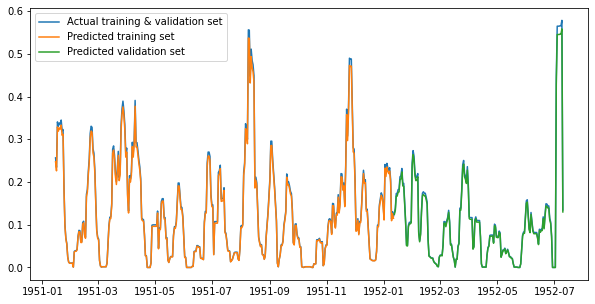

In [12]:
# Display training and validation time-series
plot_actual_vs_predict_sindy_train_val(y_train_short, y_val_short, yhat_poly_short_train, yhat_poly_short_val)

In [13]:
# Scores for training
rmse_poly_short_train = mean_squared_error(y_train_short, yhat_poly_short_train, squared = False)
mae_poly_short_train = mean_absolute_error(y_train_short, yhat_poly_short_train)
r2_poly_short_train = r2_score(y_train_short, yhat_poly_short_train)

# Scores for validation
rmse_poly_short_val = mean_squared_error(y_val_short, yhat_poly_short_val, squared = False)
mae_poly_short_val = mean_absolute_error(y_val_short, yhat_poly_short_val)
r2_poly_short_val = r2_score(y_val_short, yhat_poly_short_val)

In [14]:
print('             MAE  |  RMSE |  R2')
print('----------------------------------')
print(f'     Train: {round(mae_poly_short_train, 3)} | {round(rmse_poly_short_train, 3)}  | {round(r2_poly_short_train, 3)}')
print(f'Validation: {round(mae_poly_short_val, 3)} | {round(rmse_poly_short_val, 3)} | {round(r2_poly_short_val, 3)}')

             MAE  |  RMSE |  R2
----------------------------------
     Train: 0.005 | 0.006  | 0.997
Validation: 0.004 | 0.005 | 0.998


In [15]:
# Predict test values
yhat_poly_short_test = model_poly_short.predict(x = y_test_short, u = X_test_short)

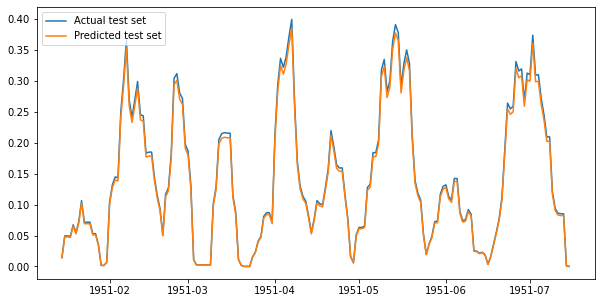

In [16]:
# Display training and validation time-series
plot_actual_vs_predict_sindy_test(y_test_short, yhat_poly_short_test)

In [17]:
#Scores for testing
rmse_poly_short_test = mean_squared_error(y_test_short, yhat_poly_short_test, squared = False)
mae_poly_short_test = mean_absolute_error(y_test_short, yhat_poly_short_test)
r2_poly_short_test = r2_score(y_test_short, yhat_poly_short_test)

In [18]:
print('              MAE  |  RMSE |  R2')
print('----------------------------------')
print(f'      Test: {round(mae_poly_short_test, 3)}  | {round(rmse_poly_short_test, 3)} | {round(r2_poly_short_test, 3)}')

              MAE  |  RMSE |  R2
----------------------------------
      Test: 0.005  | 0.006 | 0.997


## Instantiate Trigonometric model for validation

In [19]:
trigo_short_dict = validate_sindy(X_train_short, y_train_short, X_val_short, y_val_short, library = 'trigonometric', max_threshold = 150)

10
20
30
40
50
60
70
80
90
100
110
120
130
140


In [20]:
lowest_val(trigo_short_dict, library = 'trigonometric')

Best models can be found at: ['0.091', '0.092', '0.093', '0.094', '0.095', '0.096', '0.097', '0.098', '0.099', '0.1', '0.101', '0.102', '0.103', '0.104', '0.105', '0.106', '0.107', '0.108', '0.109', '0.11', '0.111', '0.112', '0.113', '0.114', '0.115', '0.116', '0.117', '0.118', '0.119', '0.12', '0.121', '0.122', '0.123', '0.124', '0.125', '0.126', '0.127', '0.128', '0.129', '0.13', '0.131', '0.132', '0.133', '0.134', '0.135', '0.136', '0.137', '0.138', '0.139', '0.14', '0.141', '0.142', '0.143', '0.144', '0.145', '0.146', '0.147', '0.148', '0.149']


threshold 0.149

In [21]:
# Create model for prediction
trigo_library = ps.FourierLibrary()
optimizer = ps.STLSQ(threshold = 0.149)
model_trigo_short = ps.SINDy(feature_library = trigo_library, feature_names = ['PRECIPITATION (T)',
                                                                            'CLOUDINESS (T-7)', 'HUMIDITY (T-7)', 'MAX_TEMP (T-7)', 'MIN_TEMP (T-7)', 'MEAN_TEMP (T-7)', 'PRECIPITATION (T-7)',
                                                                            'CLOUDINESS (T-6)', 'HUMIDITY (T-6)', 'MAX_TEMP (T-6)', 'MIN_TEMP (T-6)', 'MEAN_TEMP (T-6)', 'PRECIPITATION (T-6)',
                                                                            'CLOUDINESS (T-5)', 'HUMIDITY (T-5)', 'MAX_TEMP (T-5)', 'MIN_TEMP (T-5)', 'MEAN_TEMP (T-5)', 'PRECIPITATION (T-5)',
                                                                            'CLOUDINESS (T-4)', 'HUMIDITY (T-4)', 'MAX_TEMP (T-4)', 'MIN_TEMP (T-4)', 'MEAN_TEMP (T-4)', 'PRECIPITATION (T-4)',
                                                                            'CLOUDINESS (T-3)', 'HUMIDITY (T-3)', 'MAX_TEMP (T-3)', 'MIN_TEMP (T-3)', 'MEAN_TEMP (T-3)', 'PRECIPITATION (T-3)',
                                                                            'CLOUDINESS (T-2)', 'HUMIDITY (T-2)', 'MAX_TEMP (T-2)', 'MIN_TEMP (T-2)', 'MEAN_TEMP (T-2)', 'PRECIPITATION (T-2)',
                                                                            'CLOUDINESS (T-1)', 'HUMIDITY (T-1)', 'MAX_TEMP (T-1)', 'MIN_TEMP (T-1)', 'MEAN_TEMP (T-1)', 'PRECIPITATION (T-1)',], discrete_time = True, optimizer = optimizer)

model_trigo_short.fit(x = y_train_short, u = X_train_short)

SINDy(differentiation_method=FiniteDifference(), discrete_time=True,
      feature_library=<pysindy.feature_library.fourier_library.FourierLibrary object at 0x7fb5c5e82e48>,
      feature_names=['PRECIPITATION (T)', 'CLOUDINESS (T-7)', 'HUMIDITY (T-7)',
                     'MAX_TEMP (T-7)', 'MIN_TEMP (T-7)', 'MEAN_TEMP (T-7)',
                     'PRECIPITATION (T-7)', 'CLOUDINESS (T-6)',
                     'HUMIDITY (T-6)', 'MAX_TEMP (T-6)',...
                     'MEAN_TEMP (T-6)', 'PRECIPITATION (T-6)',
                     'CLOUDINESS (T-5)', 'HUMIDITY (T-5)', 'MAX_TEMP (T-5)',
                     'MIN_TEMP (T-5)', 'MEAN_TEMP (T-5)', 'PRECIPITATION (T-5)',
                     'CLOUDINESS (T-4)', 'HUMIDITY (T-4)', 'MAX_TEMP (T-4)',
                     'MIN_TEMP (T-4)', 'MEAN_TEMP (T-4)', 'PRECIPITATION (T-4)',
                     'CLOUDINESS (T-3)', 'HUMIDITY (T-3)', 'MAX_TEMP (T-3)',
                     'MIN_TEMP (T-3)', 'MEAN_TEMP (T-3)', ...],
      optimizer=STLSQ(thre

In [22]:
model_trigo_short.print()

PRECIPITATION (T)[k+1] = 1.084 sin(1 PRECIPITATION (T)[k]) + 0.514 sin(1 PRECIPITATION (T-7)[k]) + -0.610 sin(1 PRECIPITATION (T-6)[k])


In [23]:
# Predict training and validation values
yhat_trigo_short_train = model_trigo_short.predict(x = y_train_short, u = X_train_short)
yhat_trigo_short_val = model_trigo_short.predict(x = y_val_short, u = X_val_short)

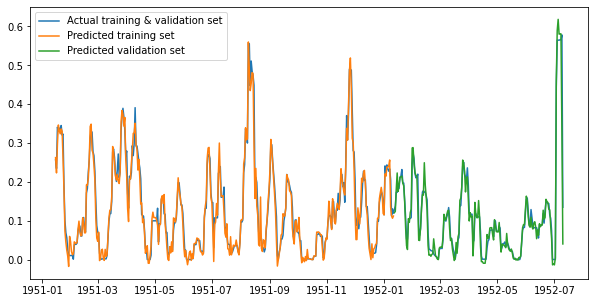

In [24]:
# Display training and validation time-series
plot_actual_vs_predict_sindy_train_val(y_train_short, y_val_short, yhat_trigo_short_train, yhat_trigo_short_val)

In [25]:
# Scores for training
rmse_trigo_short_train = mean_squared_error(y_train_short, yhat_trigo_short_train, squared = False)
mae_trigo_short_train = mean_absolute_error(y_train_short, yhat_trigo_short_train)
r2_trigo_short_train = r2_score(y_train_short, yhat_trigo_short_train)

# Scores for validation
rmse_trigo_short_val = mean_squared_error(y_val_short, yhat_trigo_short_val, squared = False)
mae_trigo_short_val = mean_absolute_error(y_val_short, yhat_trigo_short_val)
r2_trigo_short_val = r2_score(y_val_short, yhat_trigo_short_val)

In [26]:
print('             MAE  |  RMSE |  R2')
print('----------------------------------')
print(f'     Train: {round(mae_trigo_short_train, 3)} | {round(rmse_trigo_short_train, 3)} | {round(r2_trigo_short_train, 3)}')
print(f'Validation: {round(mae_trigo_short_val, 3)} | {round(rmse_trigo_short_val, 3)} | {round(r2_trigo_short_val, 3)}')

             MAE  |  RMSE |  R2
----------------------------------
     Train: 0.017 | 0.025 | 0.955
Validation: 0.014 | 0.026 | 0.945


In [27]:
# Predict test values
yhat_trigo_short_test = model_trigo_short.predict(x = y_test_short, u = X_test_short)

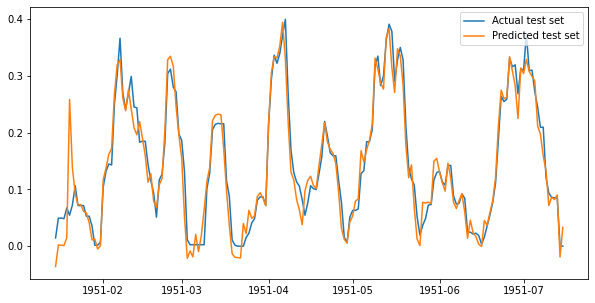

In [28]:
# Display training and validation time-series
plot_actual_vs_predict_sindy_test(y_test_short, yhat_trigo_short_test)

In [29]:
# Scores for testing
rmse_trigo_short_test = mean_squared_error(y_test_short, yhat_trigo_short_test, squared = False)
mae_trigo_short_test = mean_absolute_error(y_test_short, yhat_trigo_short_test)
r2_trigo_short_test = r2_score(y_test_short, yhat_trigo_short_test)

In [30]:
print('              MAE  |  RMSE |  R2')
print('----------------------------------')
print(f'      Test: {round(mae_trigo_short_test, 3)}  | {round(rmse_trigo_short_test, 3)} | {round(r2_trigo_short_test, 3)}')

              MAE  |  RMSE |  R2
----------------------------------
      Test: 0.021  | 0.03 | 0.927


## Instantiate combined model for validation

In [31]:
combined_short_dict = validate_sindy(X_train_short, y_train_short, X_val_short, y_val_short, library = 'combined', max_threshold = 150)

10
20
30
40
50
60
70
80
90
100
110
120
130
140


In [32]:
lowest_val(combined_short_dict, library = 'combined')

Best models can be found at: ['2_0.113', '2_0.114', '2_0.115', '2_0.116', '2_0.117']


degree 2 threshold 0.117

In [33]:
# Create model for prediction
combined_library = ps.PolynomialLibrary(degree = 2) + ps.FourierLibrary()

optimizer = ps.STLSQ(threshold = 0.117)
model_combined_short = ps.SINDy(feature_library = combined_library, feature_names = ['PRECIPITATION (T)',
                                                                            'CLOUDINESS (T-7)', 'HUMIDITY (T-7)', 'MAX_TEMP (T-7)', 'MIN_TEMP (T-7)', 'MEAN_TEMP (T-7)', 'PRECIPITATION (T-7)',
                                                                            'CLOUDINESS (T-6)', 'HUMIDITY (T-6)', 'MAX_TEMP (T-6)', 'MIN_TEMP (T-6)', 'MEAN_TEMP (T-6)', 'PRECIPITATION (T-6)',
                                                                            'CLOUDINESS (T-5)', 'HUMIDITY (T-5)', 'MAX_TEMP (T-5)', 'MIN_TEMP (T-5)', 'MEAN_TEMP (T-5)', 'PRECIPITATION (T-5)',
                                                                            'CLOUDINESS (T-4)', 'HUMIDITY (T-4)', 'MAX_TEMP (T-4)', 'MIN_TEMP (T-4)', 'MEAN_TEMP (T-4)', 'PRECIPITATION (T-4)',
                                                                            'CLOUDINESS (T-3)', 'HUMIDITY (T-3)', 'MAX_TEMP (T-3)', 'MIN_TEMP (T-3)', 'MEAN_TEMP (T-3)', 'PRECIPITATION (T-3)',
                                                                            'CLOUDINESS (T-2)', 'HUMIDITY (T-2)', 'MAX_TEMP (T-2)', 'MIN_TEMP (T-2)', 'MEAN_TEMP (T-2)', 'PRECIPITATION (T-2)',
                                                                            'CLOUDINESS (T-1)', 'HUMIDITY (T-1)', 'MAX_TEMP (T-1)', 'MIN_TEMP (T-1)', 'MEAN_TEMP (T-1)', 'PRECIPITATION (T-1)',], discrete_time = True, optimizer = optimizer)

model_combined_short.fit(x = y_train_short, u = X_train_short)

SINDy(differentiation_method=FiniteDifference(), discrete_time=True,
      feature_library=<pysindy.feature_library.base.ConcatLibrary object at 0x7fb5c50ca6d8>,
      feature_names=['PRECIPITATION (T)', 'CLOUDINESS (T-7)', 'HUMIDITY (T-7)',
                     'MAX_TEMP (T-7)', 'MIN_TEMP (T-7)', 'MEAN_TEMP (T-7)',
                     'PRECIPITATION (T-7)', 'CLOUDINESS (T-6)',
                     'HUMIDITY (T-6)', 'MAX_TEMP (T-6)', 'MIN_TEMP (T-...
                     'MEAN_TEMP (T-6)', 'PRECIPITATION (T-6)',
                     'CLOUDINESS (T-5)', 'HUMIDITY (T-5)', 'MAX_TEMP (T-5)',
                     'MIN_TEMP (T-5)', 'MEAN_TEMP (T-5)', 'PRECIPITATION (T-5)',
                     'CLOUDINESS (T-4)', 'HUMIDITY (T-4)', 'MAX_TEMP (T-4)',
                     'MIN_TEMP (T-4)', 'MEAN_TEMP (T-4)', 'PRECIPITATION (T-4)',
                     'CLOUDINESS (T-3)', 'HUMIDITY (T-3)', 'MAX_TEMP (T-3)',
                     'MIN_TEMP (T-3)', 'MEAN_TEMP (T-3)', ...],
      optimizer=STLSQ(th

In [34]:
model_combined_short.print()

PRECIPITATION (T)[k+1] = -1.978 PRECIPITATION (T)[k] + -0.173 PRECIPITATION (T-7)[k] PRECIPITATION (T-6)[k] + 3.026 sin(1 PRECIPITATION (T)[k])


In [35]:
# Predict training and validation values
yhat_combined_short_train = model_combined_short.predict(x = y_train_short, u = X_train_short)
yhat_combined_short_val = model_combined_short.predict(x = y_val_short, u = X_val_short)

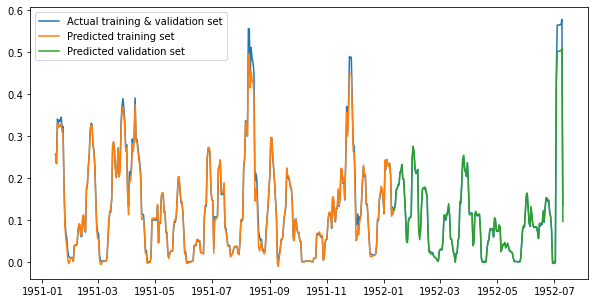

In [36]:
# Display training and validation time-series
plot_actual_vs_predict_sindy_train_val(y_train_short, y_val_short, yhat_combined_short_train, yhat_combined_short_val)

In [37]:
# Scores for training
rmse_combined_short_train = mean_squared_error(y_train_short, yhat_combined_short_train, squared = False)
mae_combined_short_train = mean_absolute_error(y_train_short, yhat_combined_short_train)
r2_combined_short_train = r2_score(y_train_short, yhat_combined_short_train)

# Scores for validation
rmse_combined_short_val = mean_squared_error(y_val_short, yhat_combined_short_val, squared = False)
mae_combined_short_val = mean_absolute_error(y_val_short, yhat_combined_short_val)
r2_combined_short_val = r2_score(y_val_short, yhat_combined_short_val)

In [38]:
print('             MAE  |  RMSE |  R2')
print('----------------------------------')
print(f'     Train: {round(mae_combined_short_train, 3)}  | {round(rmse_combined_short_train, 3)} | {round(r2_combined_short_train, 3)}')
print(f'Validation: {round(mae_combined_short_val, 3)} | {round(rmse_combined_short_val, 3)} | {round(r2_combined_short_val, 3)}')

             MAE  |  RMSE |  R2
----------------------------------
     Train: 0.007  | 0.012 | 0.99
Validation: 0.005 | 0.012 | 0.988


In [39]:
# Predict test values
yhat_combined_short_test = model_combined_short.predict(x = y_test_short, u = X_test_short)

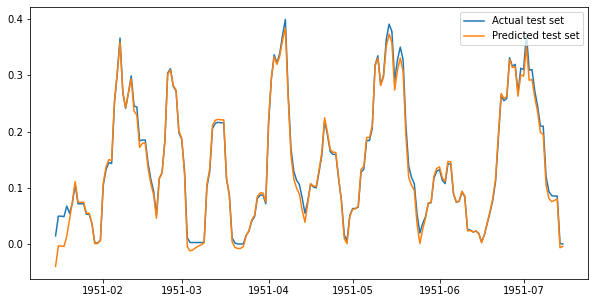

In [40]:
# Display training and validation time-series
plot_actual_vs_predict_sindy_test(y_test_short, yhat_combined_short_test)

In [41]:
# Scores for testing
rmse_combined_short_test = mean_squared_error(y_test_short, yhat_combined_short_test, squared = False)
mae_combined_short_test = mean_absolute_error(y_test_short, yhat_combined_short_test)
r2_combined_short_test = r2_score(y_test_short, yhat_combined_short_test)

In [42]:
print('              MAE  |  RMSE |  R2')
print('----------------------------------')
print(f'      Test: {round(mae_combined_short_test, 3)}  | {round(rmse_combined_short_test, 3)} | {round(r2_combined_short_test, 3)}')

              MAE  |  RMSE |  R2
----------------------------------
      Test: 0.007  | 0.012 | 0.988


# Create supervised learning problem (long)

In [43]:
X_train_long, X_val_long, X_test_long, y_train_long, y_val_long, y_test_long = multivariate_supervised_learning('long')

## Instantiate Polynomial model for validation

In [44]:
poly_long_dict = validate_sindy(X_train_long, y_train_long, X_val_long, y_val_long, library = 'polynomial', max_threshold = 150)

10
20
30
40
50
60
70
80
90
100
110
120
130
140


In [45]:
lowest_val(poly_long_dict, library = 'polynomial')

Best models can be found at: ['1_0.132', '1_0.133', '1_0.134', '1_0.135', '1_0.136', '1_0.137', '1_0.138', '1_0.139', '1_0.14', '1_0.141', '1_0.142', '1_0.143', '1_0.144', '1_0.145', '1_0.146', '1_0.147', '1_0.148', '1_0.149']


degree 1 threshold 0.149

In [46]:
# Create model for prediction
poly_library = ps.PolynomialLibrary(degree = 1)
optimizer = ps.STLSQ(threshold = 0.149)
model_poly_long = ps.SINDy(feature_library = poly_library, feature_names = ['PRECIPITATION (T)',
                                                                            'CLOUDINESS (T-7)', 'HUMIDITY (T-7)', 'MAX_TEMP (T-7)', 'MIN_TEMP (T-7)', 'MEAN_TEMP (T-7)', 'PRECIPITATION (T-7)',
                                                                            'CLOUDINESS (T-6)', 'HUMIDITY (T-6)', 'MAX_TEMP (T-6)', 'MIN_TEMP (T-6)', 'MEAN_TEMP (T-6)', 'PRECIPITATION (T-6)',
                                                                            'CLOUDINESS (T-5)', 'HUMIDITY (T-5)', 'MAX_TEMP (T-5)', 'MIN_TEMP (T-5)', 'MEAN_TEMP (T-5)', 'PRECIPITATION (T-5)',
                                                                            'CLOUDINESS (T-4)', 'HUMIDITY (T-4)', 'MAX_TEMP (T-4)', 'MIN_TEMP (T-4)', 'MEAN_TEMP (T-4)', 'PRECIPITATION (T-4)',
                                                                            'CLOUDINESS (T-3)', 'HUMIDITY (T-3)', 'MAX_TEMP (T-3)', 'MIN_TEMP (T-3)', 'MEAN_TEMP (T-3)', 'PRECIPITATION (T-3)',
                                                                            'CLOUDINESS (T-2)', 'HUMIDITY (T-2)', 'MAX_TEMP (T-2)', 'MIN_TEMP (T-2)', 'MEAN_TEMP (T-2)', 'PRECIPITATION (T-2)',
                                                                            'CLOUDINESS (T-1)', 'HUMIDITY (T-1)', 'MAX_TEMP (T-1)', 'MIN_TEMP (T-1)', 'MEAN_TEMP (T-1)', 'PRECIPITATION (T-1)',], discrete_time = True, optimizer = optimizer)

model_poly_long.fit(x = y_train_long, u = X_train_long)

SINDy(differentiation_method=FiniteDifference(), discrete_time=True,
      feature_library=PolynomialLibrary(degree=1),
      feature_names=['PRECIPITATION (T)', 'CLOUDINESS (T-7)', 'HUMIDITY (T-7)',
                     'MAX_TEMP (T-7)', 'MIN_TEMP (T-7)', 'MEAN_TEMP (T-7)',
                     'PRECIPITATION (T-7)', 'CLOUDINESS (T-6)',
                     'HUMIDITY (T-6)', 'MAX_TEMP (T-6)', 'MIN_TEMP (T-6)',
                     'MEAN_TEMP (T-6)', 'PRECIPITATION (T-6)',
                     'CLOUDINESS (T-5)', 'HUMIDITY (T-5)', 'MAX_TEMP (T-5)',
                     'MIN_TEMP (T-5)', 'MEAN_TEMP (T-5)', 'PRECIPITATION (T-5)',
                     'CLOUDINESS (T-4)', 'HUMIDITY (T-4)', 'MAX_TEMP (T-4)',
                     'MIN_TEMP (T-4)', 'MEAN_TEMP (T-4)', 'PRECIPITATION (T-4)',
                     'CLOUDINESS (T-3)', 'HUMIDITY (T-3)', 'MAX_TEMP (T-3)',
                     'MIN_TEMP (T-3)', 'MEAN_TEMP (T-3)', ...],
      optimizer=STLSQ(threshold=0.149))

In [47]:
model_poly_long.print()

PRECIPITATION (T)[k+1] = 1.022 PRECIPITATION (T)[k] + 0.476 PRECIPITATION (T-7)[k] + -0.528 PRECIPITATION (T-6)[k]


In [48]:
# Predict training and validation values
yhat_poly_long_train = model_poly_long.predict(x = y_train_long, u = X_train_long)
yhat_poly_long_val = model_poly_long.predict(x = y_val_long, u = X_val_long)

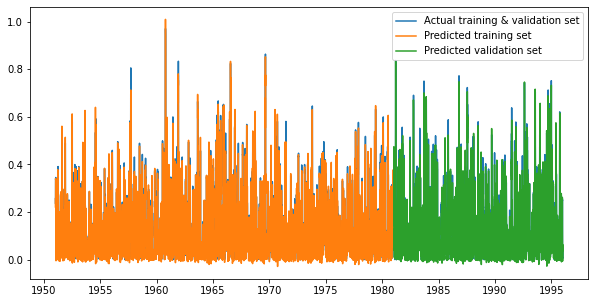

In [49]:
# Display training and validation time-series
plot_actual_vs_predict_sindy_train_val(y_train_long, y_val_long, yhat_poly_long_train, yhat_poly_long_val)

In [50]:
# Scores for training
rmse_poly_long_train = mean_squared_error(y_train_long, yhat_poly_long_train, squared = False)
mae_poly_long_train = mean_absolute_error(y_train_long, yhat_poly_long_train)
r2_poly_long_train = r2_score(y_train_long, yhat_poly_long_train)

# Scores for validation
rmse_poly_long_val = mean_squared_error(y_val_long, yhat_poly_long_val, squared = False)
mae_poly_long_val = mean_absolute_error(y_val_long, yhat_poly_long_val)
r2_poly_long_val = r2_score(y_val_long, yhat_poly_long_val)

In [51]:
print('             MAE  |  RMSE |  R2')
print('----------------------------------')
print(f'     Train: {round(mae_poly_long_train, 3)} | {round(rmse_poly_long_train, 3)} | {round(r2_poly_long_train, 3)}')
print(f'Validation: {round(mae_poly_long_val, 3)} | {round(rmse_poly_long_val, 3)}  | {round(r2_poly_long_val, 3)}')

             MAE  |  RMSE |  R2
----------------------------------
     Train: 0.015 | 0.026 | 0.958
Validation: 0.016 | 0.026  | 0.963


In [52]:
# Predict test values
yhat_poly_long_test = model_poly_long.predict(x = y_test_long, u = X_test_long)

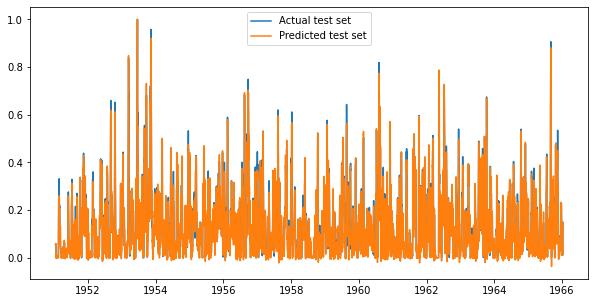

In [53]:
# Display training and validation time-series
plot_actual_vs_predict_sindy_test(y_test_long, yhat_poly_long_test)

In [54]:
#Scores for testing
rmse_poly_long_test = mean_squared_error(y_test_long, yhat_poly_long_test, squared = False)
mae_poly_long_test = mean_absolute_error(y_test_long, yhat_poly_long_test)
r2_poly_long_test = r2_score(y_test_long, yhat_poly_long_test)

In [55]:
print('              MAE  |  RMSE |  R2')
print('----------------------------------')
print(f'      Test: {round(mae_poly_long_test, 3)}  | {round(rmse_poly_long_test, 3)} | {round(r2_poly_long_test, 3)}')

              MAE  |  RMSE |  R2
----------------------------------
      Test: 0.017  | 0.028 | 0.96


## Instantiate Trigonometric model for validation

In [56]:
trigo_long_dict = validate_sindy(X_train_long, y_train_long, X_val_long, y_val_long, library = 'trigonometric', max_threshold = 150)

10
20
30
40
50
60
70
80
90
100
110
120
130
140


In [57]:
lowest_val(trigo_long_dict, library = 'trigonometric')

Best models can be found at: ['0.111', '0.112', '0.113', '0.114', '0.115', '0.141', '0.142', '0.143', '0.144', '0.145', '0.146', '0.147', '0.148', '0.149']


threshold 0.149

In [58]:
# Create model for prediction
trigo_library = ps.FourierLibrary()
optimizer = ps.STLSQ(threshold = 0.149)
model_trigo_long = ps.SINDy(feature_library = trigo_library, feature_names = ['PRECIPITATION (T)',
                                                                            'CLOUDINESS (T-7)', 'HUMIDITY (T-7)', 'MAX_TEMP (T-7)', 'MIN_TEMP (T-7)', 'MEAN_TEMP (T-7)', 'PRECIPITATION (T-7)',
                                                                            'CLOUDINESS (T-6)', 'HUMIDITY (T-6)', 'MAX_TEMP (T-6)', 'MIN_TEMP (T-6)', 'MEAN_TEMP (T-6)', 'PRECIPITATION (T-6)',
                                                                            'CLOUDINESS (T-5)', 'HUMIDITY (T-5)', 'MAX_TEMP (T-5)', 'MIN_TEMP (T-5)', 'MEAN_TEMP (T-5)', 'PRECIPITATION (T-5)',
                                                                            'CLOUDINESS (T-4)', 'HUMIDITY (T-4)', 'MAX_TEMP (T-4)', 'MIN_TEMP (T-4)', 'MEAN_TEMP (T-4)', 'PRECIPITATION (T-4)',
                                                                            'CLOUDINESS (T-3)', 'HUMIDITY (T-3)', 'MAX_TEMP (T-3)', 'MIN_TEMP (T-3)', 'MEAN_TEMP (T-3)', 'PRECIPITATION (T-3)',
                                                                            'CLOUDINESS (T-2)', 'HUMIDITY (T-2)', 'MAX_TEMP (T-2)', 'MIN_TEMP (T-2)', 'MEAN_TEMP (T-2)', 'PRECIPITATION (T-2)',
                                                                            'CLOUDINESS (T-1)', 'HUMIDITY (T-1)', 'MAX_TEMP (T-1)', 'MIN_TEMP (T-1)', 'MEAN_TEMP (T-1)', 'PRECIPITATION (T-1)',], discrete_time = True, optimizer = optimizer)

model_trigo_long.fit(x = y_train_long, u = X_train_long)

SINDy(differentiation_method=FiniteDifference(), discrete_time=True,
      feature_library=<pysindy.feature_library.fourier_library.FourierLibrary object at 0x7fb5beaa4b38>,
      feature_names=['PRECIPITATION (T)', 'CLOUDINESS (T-7)', 'HUMIDITY (T-7)',
                     'MAX_TEMP (T-7)', 'MIN_TEMP (T-7)', 'MEAN_TEMP (T-7)',
                     'PRECIPITATION (T-7)', 'CLOUDINESS (T-6)',
                     'HUMIDITY (T-6)', 'MAX_TEMP (T-6)',...
                     'MEAN_TEMP (T-6)', 'PRECIPITATION (T-6)',
                     'CLOUDINESS (T-5)', 'HUMIDITY (T-5)', 'MAX_TEMP (T-5)',
                     'MIN_TEMP (T-5)', 'MEAN_TEMP (T-5)', 'PRECIPITATION (T-5)',
                     'CLOUDINESS (T-4)', 'HUMIDITY (T-4)', 'MAX_TEMP (T-4)',
                     'MIN_TEMP (T-4)', 'MEAN_TEMP (T-4)', 'PRECIPITATION (T-4)',
                     'CLOUDINESS (T-3)', 'HUMIDITY (T-3)', 'MAX_TEMP (T-3)',
                     'MIN_TEMP (T-3)', 'MEAN_TEMP (T-3)', ...],
      optimizer=STLSQ(thre

In [59]:
model_trigo_long.print()

PRECIPITATION (T)[k+1] = 1.055 sin(1 PRECIPITATION (T)[k]) + 0.489 sin(1 PRECIPITATION (T-7)[k]) + -0.551 sin(1 PRECIPITATION (T-6)[k])


In [60]:
# Predict training and validation values
yhat_trigo_long_train = model_trigo_long.predict(x = y_train_long, u = X_train_long)
yhat_trigo_long_val = model_trigo_long.predict(x = y_val_long, u = X_val_long)

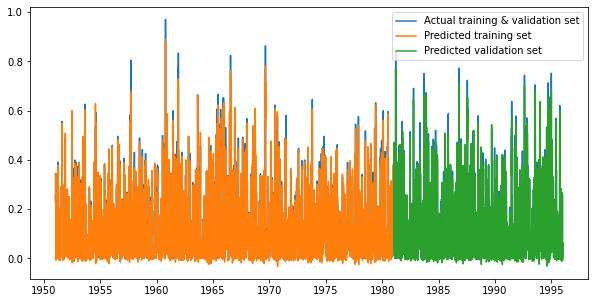

In [61]:
# Display training and validation time-series
plot_actual_vs_predict_sindy_train_val(y_train_long, y_val_long, yhat_trigo_long_train, yhat_trigo_long_val)

In [62]:
# Scores for training
rmse_trigo_long_train = mean_squared_error(y_train_long, yhat_trigo_long_train, squared = False)
mae_trigo_long_train = mean_absolute_error(y_train_long, yhat_trigo_long_train)
r2_trigo_long_train = r2_score(y_train_long, yhat_trigo_long_train)

# Scores for validation
rmse_trigo_long_val = mean_squared_error(y_val_long, yhat_trigo_long_val, squared = False)
mae_trigo_long_val = mean_absolute_error(y_val_long, yhat_trigo_long_val)
r2_trigo_long_val = r2_score(y_val_long, yhat_trigo_long_val)

In [63]:
print('             MAE  |  RMSE |  R2')
print('----------------------------------')
print(f'     Train: {round(mae_trigo_long_train, 3)} | {round(rmse_trigo_long_train, 3)} | {round(r2_trigo_long_train, 3)}')
print(f'Validation: {round(mae_trigo_long_val, 3)} | {round(rmse_trigo_long_val, 3)} | {round(r2_trigo_long_val, 3)}')

             MAE  |  RMSE |  R2
----------------------------------
     Train: 0.016 | 0.026 | 0.957
Validation: 0.016 | 0.027 | 0.962


In [64]:
# Predict test values
yhat_trigo_long_test = model_trigo_long.predict(x = y_test_long, u = X_test_long)

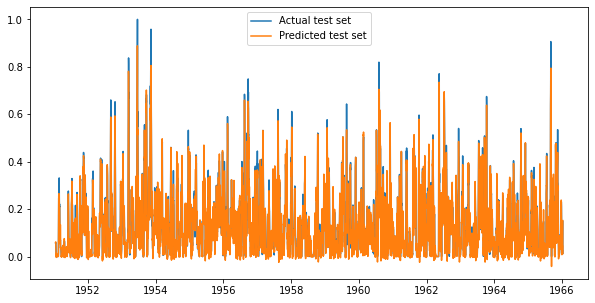

In [65]:
# Display training and validation time-series
plot_actual_vs_predict_sindy_test(y_test_long, yhat_trigo_long_test)

In [66]:
# Scores for testing
rmse_trigo_long_test = mean_squared_error(y_test_long, yhat_trigo_long_test, squared = False)
mae_trigo_long_test = mean_absolute_error(y_test_long, yhat_trigo_long_test)
r2_trigo_long_test = r2_score(y_test_long, yhat_trigo_long_test)

In [67]:
print('              MAE  |  RMSE |  R2')
print('----------------------------------')
print(f'      Test: {round(mae_trigo_long_test, 3)}  | {round(rmse_trigo_long_test, 3)} | {round(r2_trigo_long_test, 3)}')

              MAE  |  RMSE |  R2
----------------------------------
      Test: 0.018  | 0.029 | 0.957


## Instantiate combined model for validation

In [68]:
combined_long_dict = validate_sindy(X_train_long, y_train_long, X_val_long, y_val_long, library = 'combined', max_threshold = 150)

10
20
30
40
50
60
70
80
90
100
110
120
130
140


In [69]:
lowest_val(combined_long_dict, library = 'combined')

Best models can be found at: ['1_0.117', '1_0.118', '1_0.119', '1_0.12', '1_0.121', '1_0.122', '1_0.123', '1_0.124', '1_0.125', '1_0.126', '1_0.127', '1_0.128', '1_0.129', '1_0.13', '1_0.131', '1_0.132', '1_0.133', '1_0.134', '1_0.135', '1_0.136', '1_0.137', '1_0.138', '1_0.139', '1_0.14', '1_0.141', '1_0.142', '1_0.143', '1_0.144', '1_0.145', '1_0.146', '1_0.147', '1_0.148', '1_0.149']


degree 1 threshold 0.149

In [70]:
# Create model for prediction
combined_library = ps.PolynomialLibrary(degree = 1) + ps.FourierLibrary()

optimizer = ps.STLSQ(threshold = 0.149)
model_combined_long = ps.SINDy(feature_library = combined_library, feature_names = ['PRECIPITATION (T)',
                                                                            'CLOUDINESS (T-7)', 'HUMIDITY (T-7)', 'MAX_TEMP (T-7)', 'MIN_TEMP (T-7)', 'MEAN_TEMP (T-7)', 'PRECIPITATION (T-7)',
                                                                            'CLOUDINESS (T-6)', 'HUMIDITY (T-6)', 'MAX_TEMP (T-6)', 'MIN_TEMP (T-6)', 'MEAN_TEMP (T-6)', 'PRECIPITATION (T-6)',
                                                                            'CLOUDINESS (T-5)', 'HUMIDITY (T-5)', 'MAX_TEMP (T-5)', 'MIN_TEMP (T-5)', 'MEAN_TEMP (T-5)', 'PRECIPITATION (T-5)',
                                                                            'CLOUDINESS (T-4)', 'HUMIDITY (T-4)', 'MAX_TEMP (T-4)', 'MIN_TEMP (T-4)', 'MEAN_TEMP (T-4)', 'PRECIPITATION (T-4)',
                                                                            'CLOUDINESS (T-3)', 'HUMIDITY (T-3)', 'MAX_TEMP (T-3)', 'MIN_TEMP (T-3)', 'MEAN_TEMP (T-3)', 'PRECIPITATION (T-3)',
                                                                            'CLOUDINESS (T-2)', 'HUMIDITY (T-2)', 'MAX_TEMP (T-2)', 'MIN_TEMP (T-2)', 'MEAN_TEMP (T-2)', 'PRECIPITATION (T-2)',
                                                                            'CLOUDINESS (T-1)', 'HUMIDITY (T-1)', 'MAX_TEMP (T-1)', 'MIN_TEMP (T-1)', 'MEAN_TEMP (T-1)', 'PRECIPITATION (T-1)',], discrete_time = True, optimizer = optimizer)

model_combined_long.fit(x = y_train_long, u = X_train_long)

SINDy(differentiation_method=FiniteDifference(), discrete_time=True,
      feature_library=<pysindy.feature_library.base.ConcatLibrary object at 0x7fb5c4ad4a58>,
      feature_names=['PRECIPITATION (T)', 'CLOUDINESS (T-7)', 'HUMIDITY (T-7)',
                     'MAX_TEMP (T-7)', 'MIN_TEMP (T-7)', 'MEAN_TEMP (T-7)',
                     'PRECIPITATION (T-7)', 'CLOUDINESS (T-6)',
                     'HUMIDITY (T-6)', 'MAX_TEMP (T-6)', 'MIN_TEMP (T-...
                     'MEAN_TEMP (T-6)', 'PRECIPITATION (T-6)',
                     'CLOUDINESS (T-5)', 'HUMIDITY (T-5)', 'MAX_TEMP (T-5)',
                     'MIN_TEMP (T-5)', 'MEAN_TEMP (T-5)', 'PRECIPITATION (T-5)',
                     'CLOUDINESS (T-4)', 'HUMIDITY (T-4)', 'MAX_TEMP (T-4)',
                     'MIN_TEMP (T-4)', 'MEAN_TEMP (T-4)', 'PRECIPITATION (T-4)',
                     'CLOUDINESS (T-3)', 'HUMIDITY (T-3)', 'MAX_TEMP (T-3)',
                     'MIN_TEMP (T-3)', 'MEAN_TEMP (T-3)', ...],
      optimizer=STLSQ(th

In [71]:
model_combined_long.print()

PRECIPITATION (T)[k+1] = 0.073 PRECIPITATION (T)[k] + 0.471 PRECIPITATION (T-7)[k] + 0.982 sin(1 PRECIPITATION (T)[k]) + -0.548 sin(1 PRECIPITATION (T-6)[k])


In [72]:
# Predict training and validation values
yhat_combined_long_train = model_combined_long.predict(x = y_train_long, u = X_train_long)
yhat_combined_long_val = model_combined_long.predict(x = y_val_long, u = X_val_long)

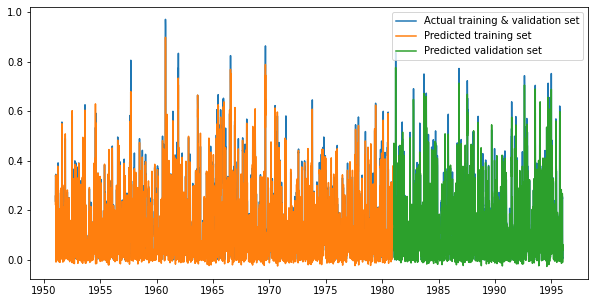

In [73]:
# Display training and validation time-series
plot_actual_vs_predict_sindy_train_val(y_train_long, y_val_long, yhat_combined_long_train, yhat_combined_long_val)

In [74]:
# Scores for training
rmse_combined_long_train = mean_squared_error(y_train_long, yhat_combined_long_train, squared = False)
mae_combined_long_train = mean_absolute_error(y_train_long, yhat_combined_long_train)
r2_combined_long_train = r2_score(y_train_long, yhat_combined_long_train)

# Scores for validation
rmse_combined_long_val = mean_squared_error(y_val_long, yhat_combined_long_val, squared = False)
mae_combined_long_val = mean_absolute_error(y_val_long, yhat_combined_long_val)
r2_combined_long_val = r2_score(y_val_long, yhat_combined_long_val)

In [75]:
print('             MAE  |  RMSE |  R2')
print('----------------------------------')
print(f'     Train: {round(mae_combined_long_train, 3)} | {round(rmse_combined_long_train, 3)} | {round(r2_combined_long_train, 3)}')
print(f'Validation: {round(mae_combined_long_val, 3)} | {round(rmse_combined_long_val, 3)} | {round(r2_combined_long_val, 3)}')

             MAE  |  RMSE |  R2
----------------------------------
     Train: 0.016 | 0.026 | 0.958
Validation: 0.016 | 0.026 | 0.963


In [76]:
# Predict test values
yhat_combined_long_test = model_combined_long.predict(x = y_test_long, u = X_test_long)

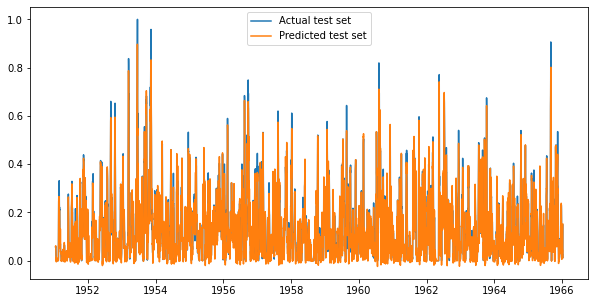

In [77]:
# Display training and validation time-series
plot_actual_vs_predict_sindy_test(y_test_long, yhat_combined_long_test)

In [78]:
# Scores for testing
rmse_combined_long_test = mean_squared_error(y_test_long, yhat_combined_long_test, squared = False)
mae_combined_long_test = mean_absolute_error(y_test_long, yhat_combined_long_test)
r2_combined_long_test = r2_score(y_test_long, yhat_combined_long_test)

In [79]:
print('              MAE  |  RMSE |  R2')
print('----------------------------------')
print(f'      Test: {round(mae_combined_long_test, 3)}  | {round(rmse_combined_long_test, 3)} | {round(r2_combined_long_test, 3)}')

              MAE  |  RMSE |  R2
----------------------------------
      Test: 0.018  | 0.029 | 0.958
